# Importing the needed modules

In [367]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns
from graphviz import Digraph
import pydot
from pprint import pprint
import networkx as nx
import random

# Reading the datasets

In [196]:
trainData = pd.read_csv('sample_train.csv')
devData = pd.read_csv('sample_dev.csv')
testData = pd.read_csv('sample_test.csv')
dataFrame = pd.DataFrame(trainData)

In [39]:
def data_init(file):
    trainData = pd.read_csv(file)
    dataFrame = pd.DataFrame(trainData)
    return dataFrame
#     dataFrame=dataFrame.drop("rating",axis=1)

In [211]:
def words_count(dataFrame):
    d = []
    if 'rating' in dataFrame.columns:
        d = dataFrame.rating
        dataFrame = dataFrame.drop('rating',axis=1)
    features = ['contains_No', 'contains_Please', 'contains_Thank', 'contains_apologize', 'contains_bad',
    'contains_clean', 'contains_comfortable', 'contains_dirty', 'contains_enjoyed', 'contains_friendly',
    'contains_glad', 'contains_good', 'contains_great', 'contains_happy', 'contains_hot', 'contains_issues',
    'contains_nice', 'contains_noise', 'contains_old', 'contains_poor', 'contains_right', 'contains_small', 
    'contains_smell', 'contains_sorry', 'contains_wonderful', 'reviews.text', 'count_reviews.text']
    
    for i in dataFrame.columns:
        c = i.replace('contains_','')
        col = []
        for j in range(0,dataFrame.shape[0]):
            if dataFrame[i][j]==1:
                col.append(dataFrame['reviews.text'][j].count(c))
            else:
                col.append(0)
        dataFrame['count_'+c]=col
    
    dataFrame = dataFrame.drop(features,axis=1)
    dataFrame = dataFrame.join(d)
    return dataFrame

In [41]:
def check_purity(data):
    
    rating_column = data[:, -1]
    unique_classes = np.unique(rating_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [42]:
def classify_data(data):
    
    rating_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(rating_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [43]:
def get_potential_splits(data):
    
    potential_splits = {}
    n_columns = data.shape[1]
    for column_index in range(n_columns - 1):        # excluding the last column which is the rating
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        potential_splits[column_index]=unique_values
        
    return potential_splits

In [45]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values > split_value]
    
    return data_below, data_above

In [46]:
def calculate_entropy(data):
    
    rating_column = data[:, -1]
    _, counts = np.unique(rating_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [47]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy



In [48]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value




In [ ]:
# def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        if len(data_below)==0 or len(data_above)==0:    
            classification = classify_data(data)
            return classification
            
        
        # instantiate sub-tree --to be converted into nodes
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} = {}".format(feature_name, split_value)
        sub_tree = {question: []}
    
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
            
        
        
        return sub_tree
    

# Implementing Node and Tree Classes

In [254]:
class Node:
    def __init__(self,key):
        self.val = key
        self.left = None
        self.right = None
        

In [255]:
class Tree:
    def __init__(self, _val = None):
        self.val = _val
        self.right, self.left = None, None
    def __iter__(self):
        yield self.val
        yield from [[], self.left][bool(self.left)]
        yield from [[], self.right][bool(self.right)]
    def _insert_vals(self, _start, _d):
        self.val = _start
        
        for a, b in zip(['left', 'right'], _d.get(_start, [])):
            if b is not None:
                setattr(self, a, Tree())
                getattr(self, a)._insert_vals(b, _d)

In [450]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    d = Digraph()
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    # recursive part
    else:    
        counter += 1
      #  sub_tree = Tree()

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        if len(data_below)==0 or len(data_above)==0:    
            classification = classify_data(data)
            return classification
            
        
        # instantiate sub-tree --to be converted into n
        feature_name = COLUMN_HEADERS[split_column]
        question = "{}  {}".format(feature_name, split_value)
        d.node(question)
#         sub_tree._insert_vals(question,)
        sub_tree = {question: []}
        
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)

        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
#         d = {frozenset(sub_tree[question].values)}
        return sub_tree
    

In [261]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split()

    # ask question
    if str(example[feature_name]) <= value:
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [291]:
def predict(df,tree):
    df=words_count(df)
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    with open('output.txt', 'w') as f:
        for text in df['classification'].tolist():
            f.write(text + '\n')
    return df['classification'].values
    

In [292]:
def calculate_accuracy(df_, tree,show=False):
    df=words_count(df_)
    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["rating"]
    
    accuracy = df["classification_correct"].mean()
    if show==True:
        #print(df.classification)
        #print(df.classification_correct)
#         print(df[['classification'],['classification_correct']])
        print(df[['classification', 'classification_correct']])
    return accuracy

In [451]:
d = words_count(dataFrame)
t = decision_tree_algorithm(d, max_depth=3)
# x=calculate_accuracy(devData,t)
# pprint(t)
# print(x)

In [457]:
with open('graph.dot','w') as out:
    for line in ('digraph G {','size="16,16";','splines=true;'):
        out.write('{}\n'.format(line)) 
        out.write('{} -> {} [ label="{}" ];\n'.format(t.keys(),))
    for start,d in t.items():
        for end,weight in m:
              out.write('{} -> {} [ label="{}" ];\n'.format(start,end,weight))
    out.write('}\n')

In [369]:
plot_tree(t,graph,parent=None,counter=0)

parent :  question_1475
child  :  count_friendly = 0
parent :  count_sorry = 0
child  :  count_dirty = 0
parent :  question_1410
child  :  count_enjoyed = 0
parent :  count_sorry = 0
child  :  count_apologize = 0
parent :  None
child  :  count_sorry = 0


In [412]:
result = json.dumps(t)
result

'{"count_sorry = 0": [{"count_dirty = 0": ["Positive", {"count_friendly = 0": ["Negative", "Positive"]}]}, {"count_apologize = 0": [{"count_enjoyed = 0": ["Negative", "Positive"]}, "Negative"]}]}'

In [294]:
ex = testData
c = predict(ex,t)

In [386]:
data = list(t.items())
an_array = np.array(data)

In [387]:
an_array

array([['count_sorry = 0',
        list([{'count_dirty = 0': ['Positive', {'count_friendly = 0': ['Negative', 'Positive']}]}, {'count_apologize = 0': [{'count_enjoyed = 0': ['Negative', 'Positive']}, 'Negative']}])]],
      dtype=object)

In [312]:
def generate_edges(graph):
    edges = []

    # for each node in graph
    for node in graph:

        # for each neighbour node of a single node
        for neighbour in graph[node]:
            # if edge exists then append
            edges.append((node, neighbour))
    return edges

In [313]:
from collections import defaultdict
graph = defaultdict(list) 
def addEdge(graph,u,v): 
    graph[u].append(v) 
  
    # definition of function 
def generate_edges(graph): 
    edges = [] 
  
    # for each node in graph 
    for node in graph: 
          
        # for each neighbour node of a single node 
        for neighbour in graph[node]: 
              
            # if edge exists then append 
            edges.append((node, neighbour)) 
    return edges 

In [385]:
m = generate_edges(t)
# split = m.split(',')
# split
G = nx.DiGraph()
G
# for j in range(0,2):
#     print(m[0][j])
#     print(m[1][j])

In [316]:
dot_data = tree.export_graphviz(m,
                                feature_names=d.columns,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_file()

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('tree.png')

AttributeError: 'dict' object has no attribute 'export_graphviz'

# Importing needed modules for Visualization

In [340]:
#Visualizing the DecisionTree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz as pgv
import pydotplus
import sklearn.tree as sktree
import json
import networkx as nx

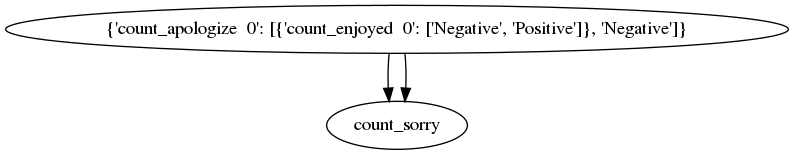

In [458]:
dot_data = StringIO()
# export_graphviz(result, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = d.columns,class_names=['Positive','Negative'])
graph = pydotplus.graph_from_dot_file('graph.dot')  
graph.write_png('Reviews.png')
Image(graph.create_png())

0.5


C:\Users\nesma\anaconda3\envs\pd-env\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


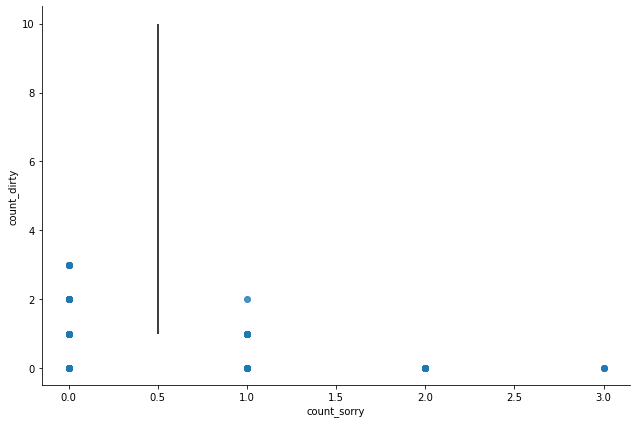

In [109]:
# plotting_df = pd.DataFrame(d , columns=df.columns)
potential_splits = get_potential_splits(d.values)
_, split_value = determine_best_split(d.values,potential_splits) 
print(split_value)
sns.lmplot(data = d , x="count_sorry" , y="count_dirty"  ,fit_reg=False , size=6 ,aspect=1.5)
plt.vlines(x=split_value , ymin=1 , ymax=10)